mps
Epoch [1/20], Loss: 1357.7078
Epoch [2/20], Loss: 1322.9131
Epoch [3/20], Loss: 1204.9243
Epoch [4/20], Loss: 1169.5732
Epoch [5/20], Loss: 1171.2297
Epoch [6/20], Loss: 1131.3237
Epoch [7/20], Loss: 1106.6184
Epoch [8/20], Loss: 1124.6676
Epoch [9/20], Loss: 1085.1892
Epoch [10/20], Loss: 1100.5699
Epoch [11/20], Loss: 1091.2040
Epoch [12/20], Loss: 1095.2722
Epoch [13/20], Loss: 1096.8188
Epoch [14/20], Loss: 1047.6130
Epoch [15/20], Loss: 1034.9235
Epoch [16/20], Loss: 1042.1079
Epoch [17/20], Loss: 1050.0782
Epoch [18/20], Loss: 1053.5945
Epoch [19/20], Loss: 1037.5753
Epoch [20/20], Loss: 1048.5110


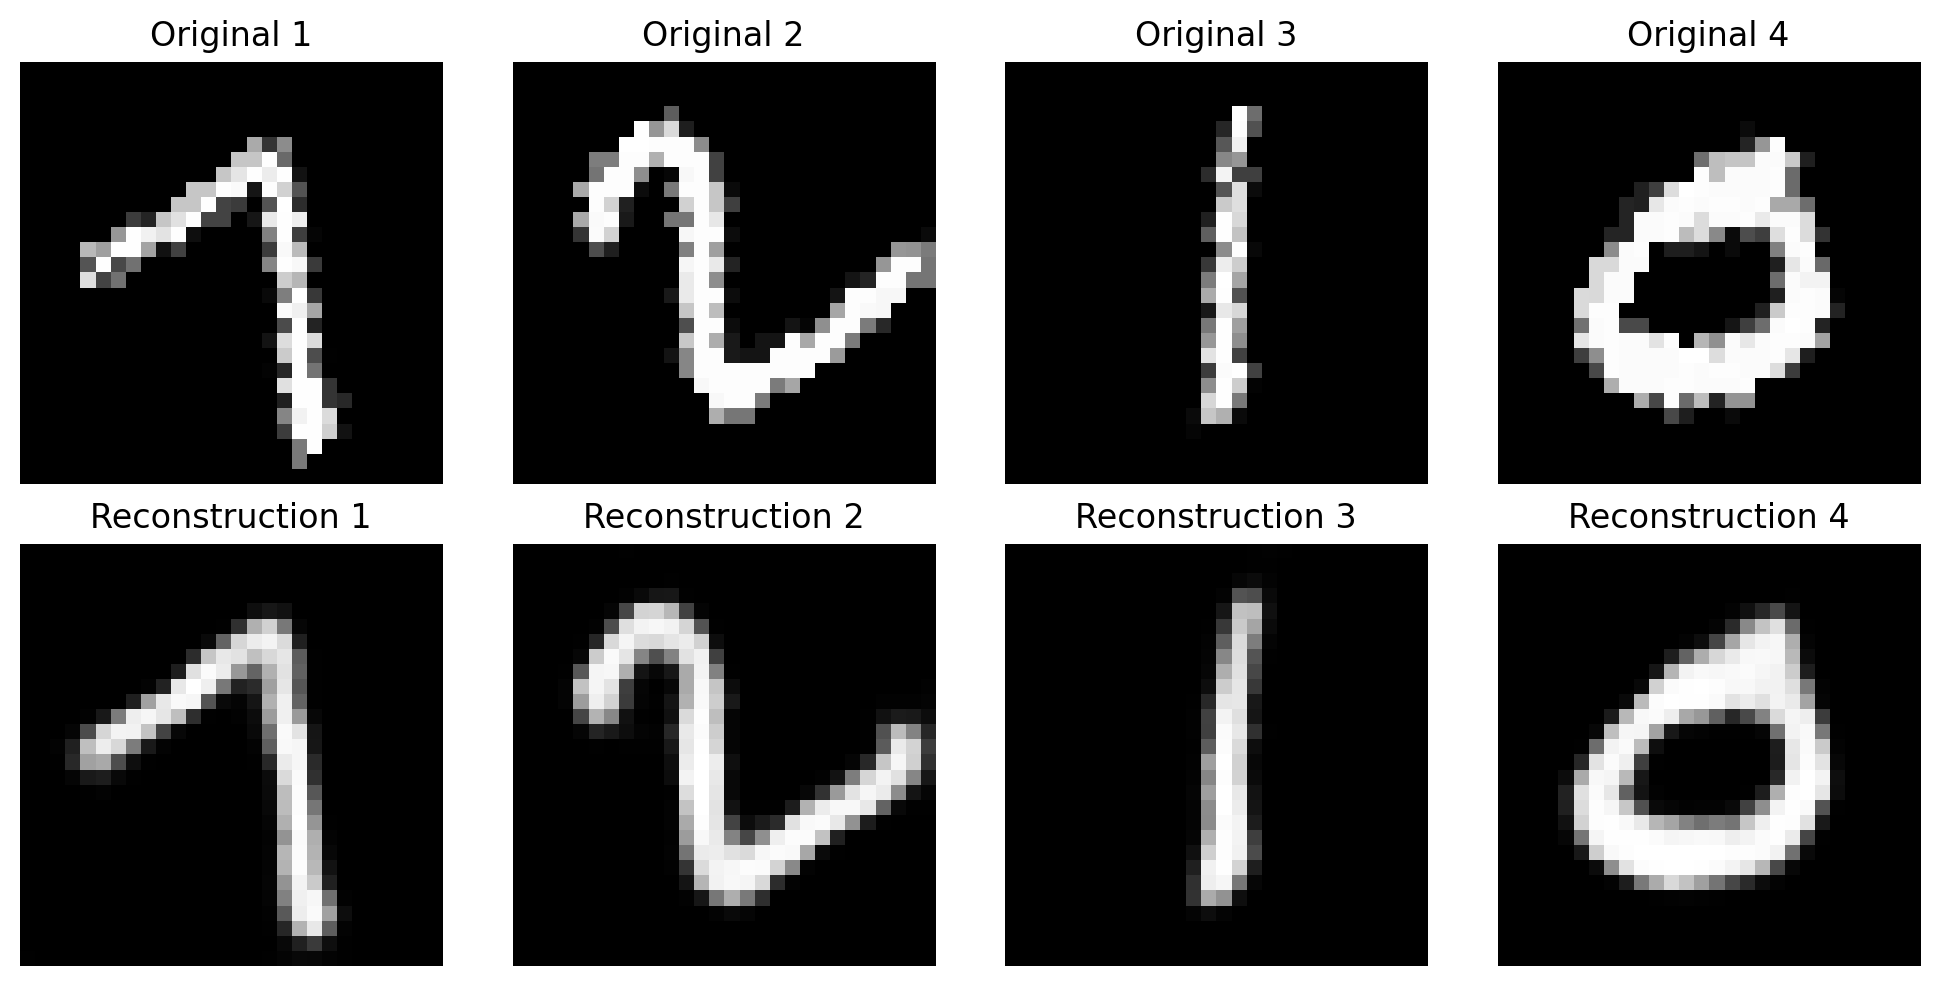

In [19]:
# -*- coding: utf-8 -*-
"""flow VAE

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1swTtVe_mpYEL9I_S_DEPryZtxkvAshO_

## Variational Autoencoders with Flows

First, we load the relevant packages:
"""

import torch; torch.manual_seed(0) #set for reproducibility!
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import seaborn as sns

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)

import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

# Load augmented data
train_images = np.load('../data/augmented/onlyrot_augmented_mnist_train_images.npy')
train_labels = np.load('../data/augmented/onlyrot_augmented_mnist_train_labels.npy')
test_images = np.load('../data/augmented/onlyrot_augmented_mnist_test_images.npy')
test_labels = np.load('../data/augmented/onlyrot_augmented_mnist_test_labels.npy')

# Convert to torch tensors
train_images = torch.from_numpy(train_images).unsqueeze(1).float()  # shape: (N, 1, 28, 28)
train_labels = torch.from_numpy(train_labels).long()
test_images = torch.from_numpy(test_images).unsqueeze(1).float()
test_labels = torch.from_numpy(test_labels).long()

# Create TensorDatasets
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

"""We can see that the various MNIST digits cluster but the latent space is not well sampled! This leads to problems down the road sampling outside of the training data distribution. We can already see this a bit when interpolating over the space:"""

# ====== MLP VAE (commented out) ======
# class VariationalAutoencoder(nn.Module):
#     def __init__(self, latent_dims):
#         super(VariationalAutoencoder, self).__init__()
#         self.enc1 = nn.Linear(784, 1024)
#         self.enc2 = nn.Linear(1024, 512)
#         self.enc3 = nn.Linear(512, latent_dims)
#         self.enc4 = nn.Linear(512, latent_dims)
#
#         self.dec1 = nn.Linear(latent_dims, 512)
#         self.dec2 = nn.Linear(512, 1024)
#         self.dec3 = nn.Linear(1024, 784)
#
#         self.N = torch.distributions.Normal(0, 1)
#         self.N.loc = self.N.loc
#         self.N.scale = self.N.scale
#         self.kl = 0
#
#     def encoder(self, x):
#         x = torch.flatten(x, start_dim=1)
#         x = F.relu(self.enc1(x))
#         x = F.relu(self.enc2(x))
#         mu = self.enc3(x)
#         sigma = torch.exp(self.enc4(x))
#         eps = self.N.sample(mu.shape).to(mu.device)
#         z = mu + sigma*eps
#         self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
#         return z
#
#     def decoder(self, z):
#         z = F.relu(self.dec1(z))
#         z = F.relu(self.dec2(z))
#         z = torch.sigmoid(self.dec3(z))
#         return z.reshape((-1, 1, 28, 28))
#
#     def forward(self, x):
#         z = self.encoder(x)
#         return self.decoder(z)

# ====== CNN VAE ======
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        # Encoder
        self.enc = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  # (B,32,14,14)
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # (B,64,7,7)
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64*7*7, latent_dim)
        self.fc_logvar = nn.Linear(64*7*7, latent_dim)
        # Decoder
        self.fc_dec = nn.Linear(latent_dim, 64*7*7)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # (B,32,14,14)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),  # (B,1,28,28)
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.enc(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z).view(-1, 64, 7, 7)
        return self.dec(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        # KL divergence
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return x_hat, kl

# ====== Training loop for ConvVAE ======
num_epochs = 20
latent_dims = 32
beta = 0.05

conv_vae = ConvVAE(latent_dims).to(device)
opt = torch.optim.Adam(conv_vae.parameters())
for epoch in range(num_epochs):
    for x, y in train_loader:
        x = x.to(device)
        opt.zero_grad()
        x_hat, kl = conv_vae(x)
        loss = ((x - x_hat)**2).sum() + beta * kl
        loss.backward()
        opt.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# ====== Show 4 examples and their reconstructions ======
examples, labels = next(iter(test_loader))
examples = examples[:4].to(device)  # Take exactly 4 examples
with torch.no_grad():
    reconstructions, _ = conv_vae(examples)
examples = examples.cpu().numpy()
reconstructions = reconstructions.cpu().numpy()
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
for i in range(4):
    axes[0, i].imshow(examples[i][0], cmap='gray')
    axes[0, i].set_title(f"Original {i+1}")
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructions[i][0], cmap='gray')
    axes[1, i].set_title(f"Reconstruction {i+1}")
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()


Computing latent representations for entire test set...
Processed batch 0/79
Processed batch 10/79
Processed batch 20/79
Processed batch 30/79
Processed batch 40/79
Processed batch 50/79
Processed batch 60/79
Processed batch 70/79
Total samples: 10000
Latent space shape: (10000, 32)


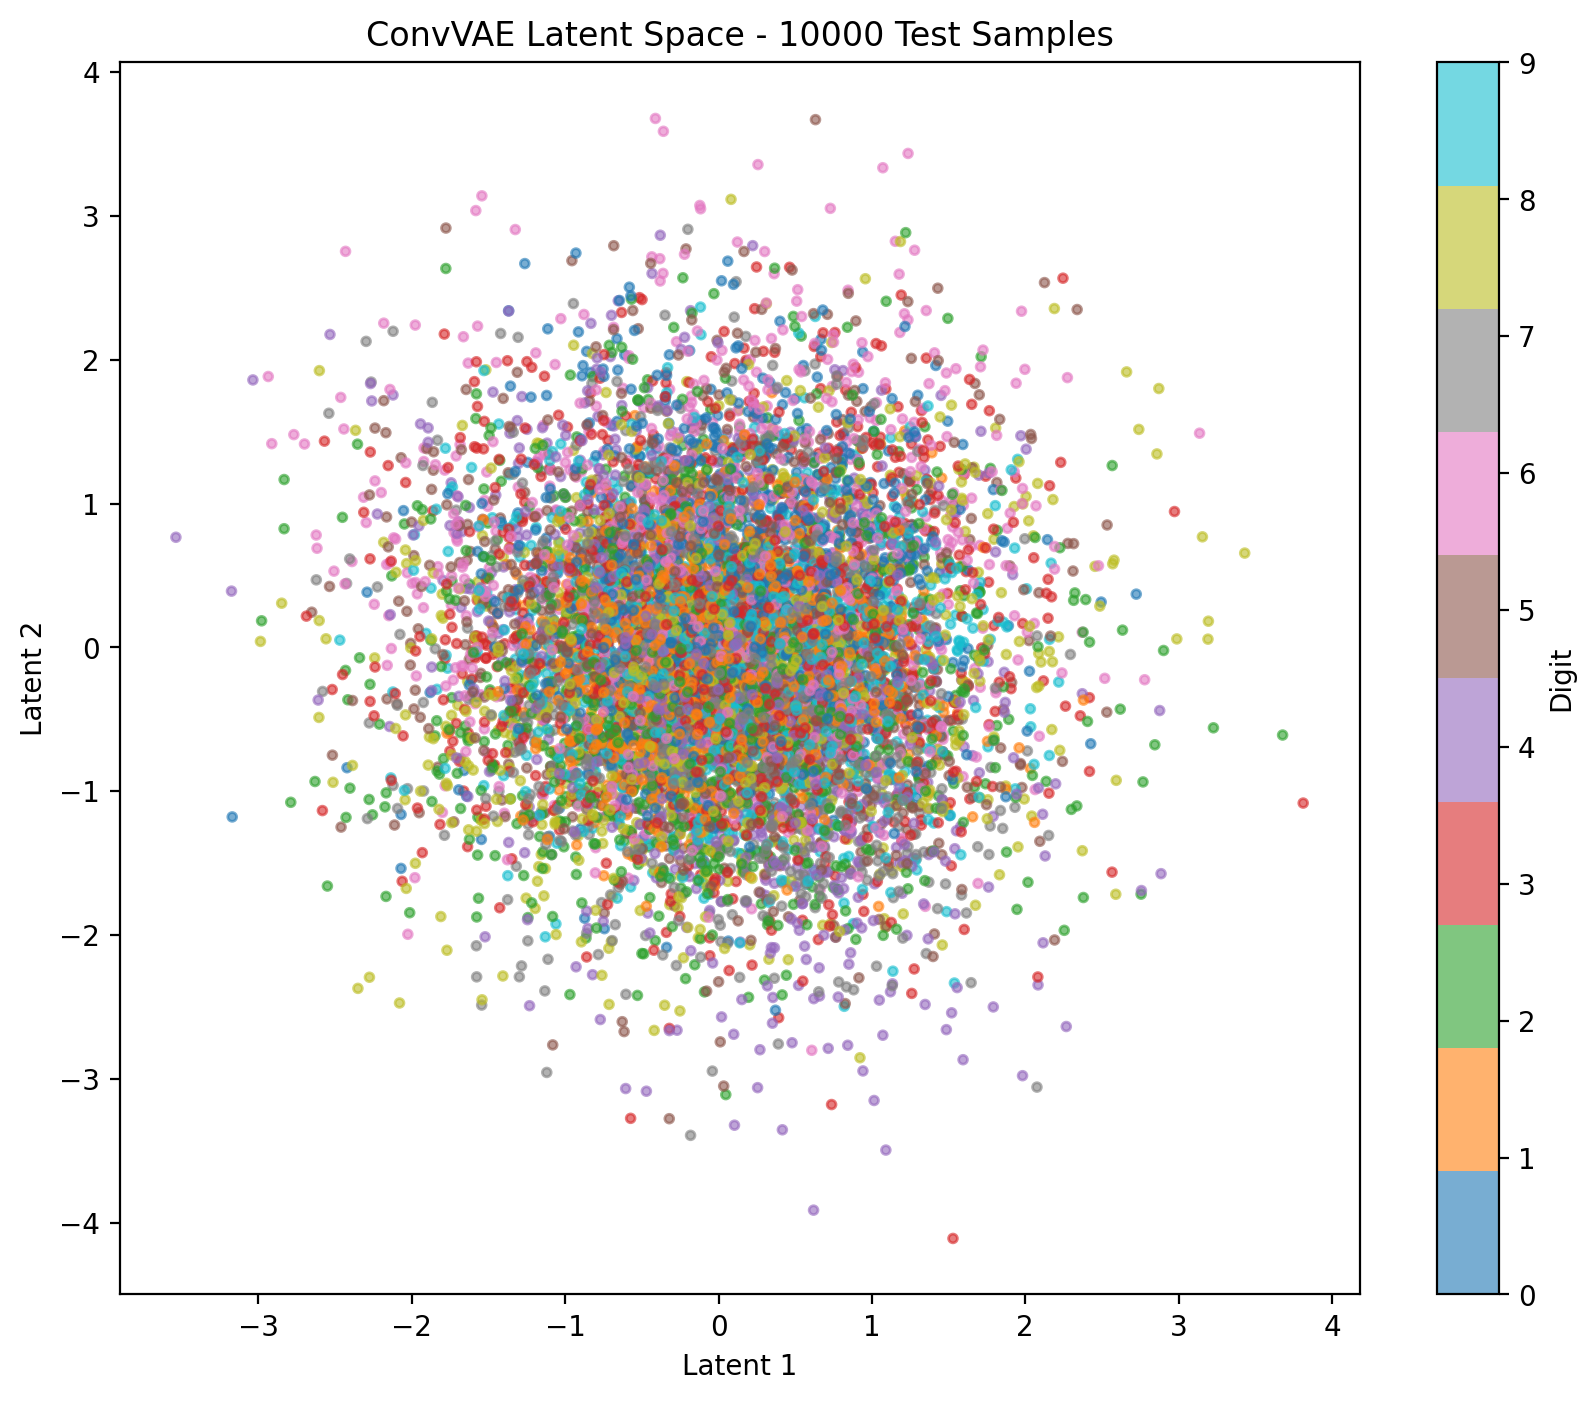

In [20]:
### Visualize latent space
# Use the entire test set for better visualization
print("Computing latent representations for entire test set...")
all_z = []
all_labels = []

conv_vae.eval()  # Set to evaluation mode
with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(test_loader):
        data = data.to(device)
        mu, logvar = conv_vae.encode(data)
        z = conv_vae.reparameterize(mu, logvar)
        all_z.append(z.cpu().numpy())
        all_labels.append(labels.numpy())

        if batch_idx % 10 == 0:
            print(f"Processed batch {batch_idx}/{len(test_loader)}")

# Concatenate all batches
all_z = np.concatenate(all_z, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print(f"Total samples: {len(all_z)}")
print(f"Latent space shape: {all_z.shape}")

plt.figure(figsize=(10, 8))
plt.scatter(all_z[:, 0], all_z[:, 1], c=all_labels, cmap='tab10', s=10, alpha=0.6)
plt.colorbar(label='Digit')
plt.xlabel("Latent 1")
plt.ylabel("Latent 2")
plt.title(f"ConvVAE Latent Space - {len(all_z)} Test Samples")
plt.show()

Computing latent representations for entire test set...
Processed batch 0/79
Processed batch 10/79
Processed batch 20/79
Processed batch 30/79
Processed batch 40/79
Processed batch 50/79
Processed batch 60/79
Processed batch 70/79
Running t-SNE...


/Users/pablom.perez/miniconda3/envs/causalfm-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/pablom.perez/miniconda3/envs/causalfm-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/pablom.perez/miniconda3/envs/causalfm-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/pablom.perez/miniconda3/envs/causalfm-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/pablom.perez/miniconda3/envs/causalfm-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/pablom.perez/miniconda3/envs/causalfm-env/lib/python3.10/site-

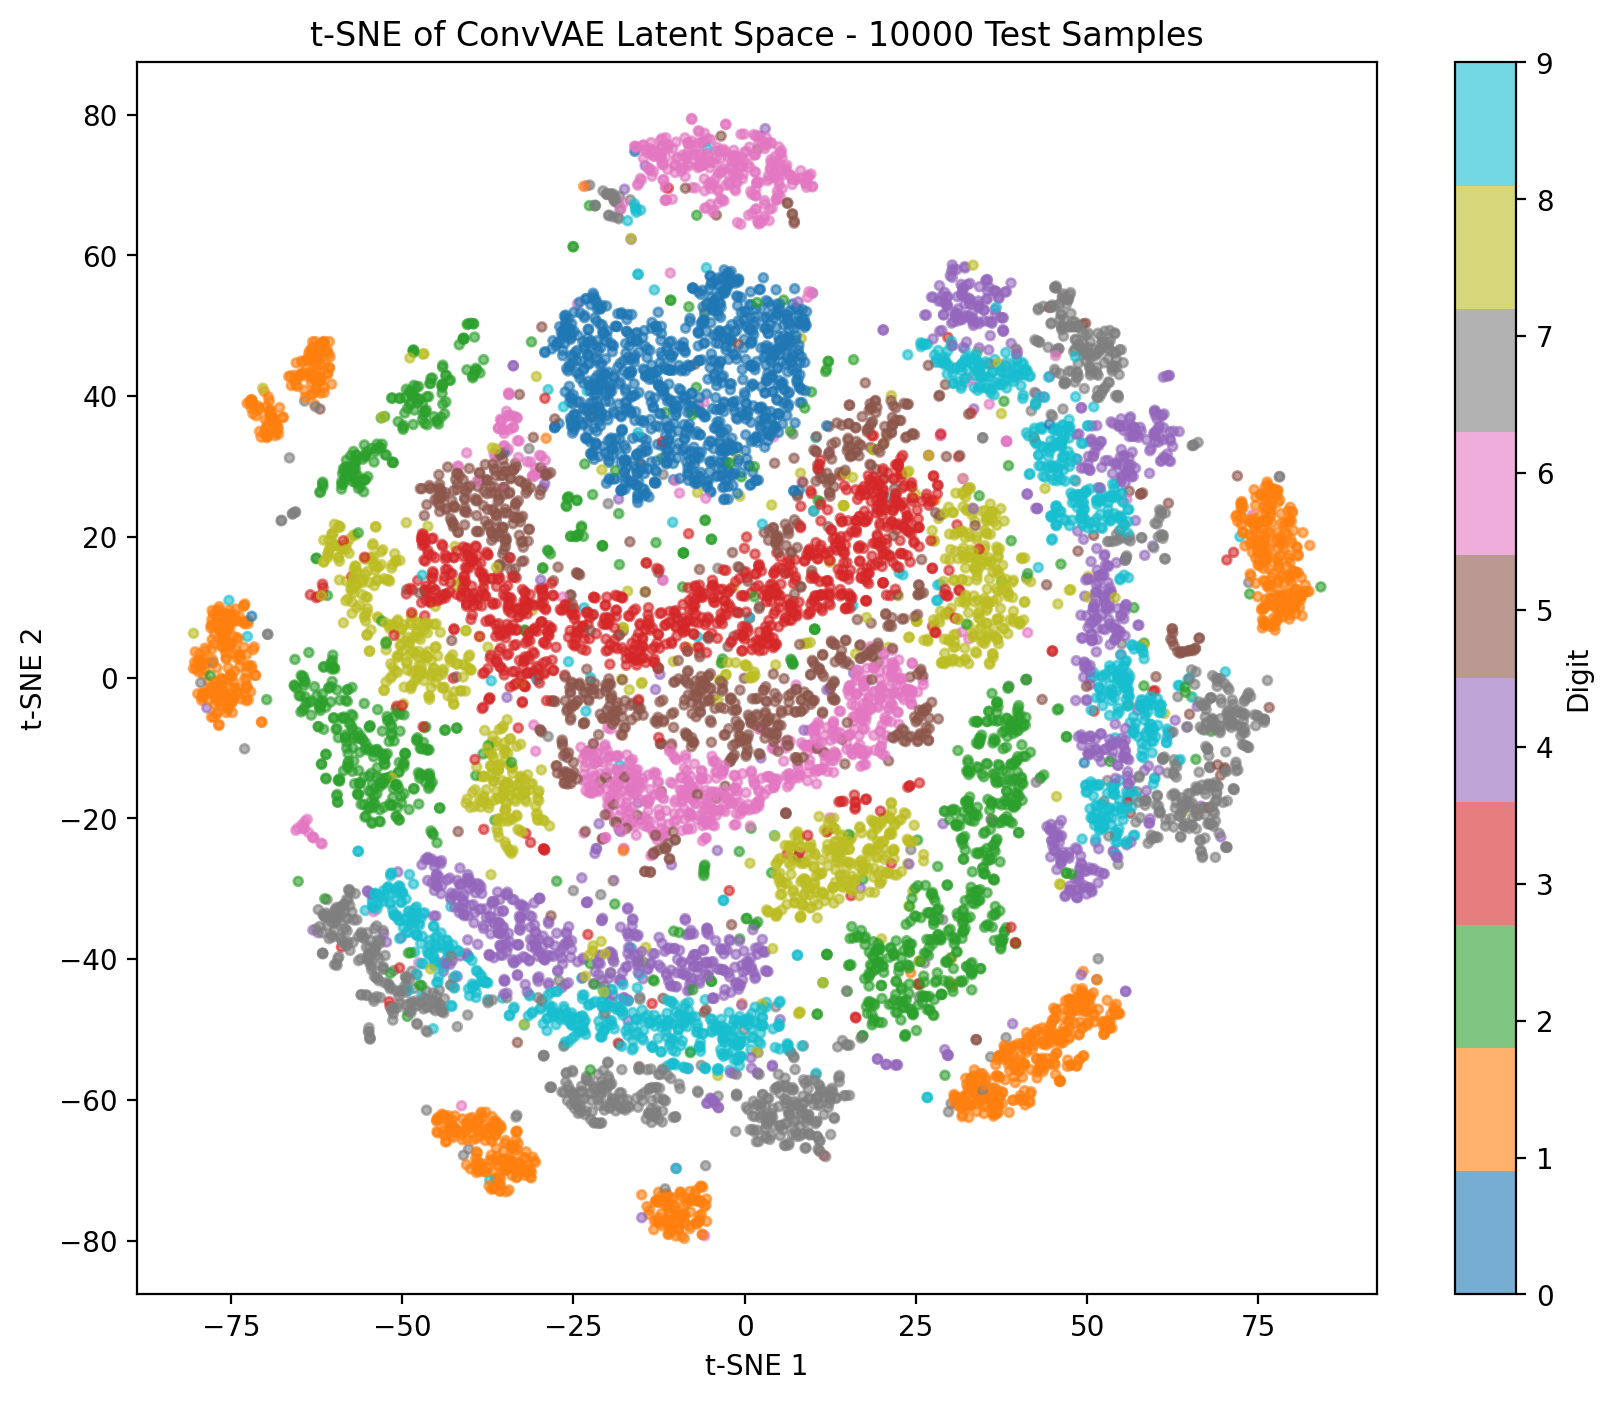

In [3]:
### Visualize latent space with t-SNE
from sklearn.manifold import TSNE

print("Computing latent representations for entire test set...")
all_z = []
all_labels = []

conv_vae.eval()
with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(test_loader):
        data = data.to(device)
        mu, logvar = conv_vae.encode(data)
        z = conv_vae.reparameterize(mu, logvar)
        all_z.append(z.cpu().numpy())
        all_labels.append(labels.numpy())
        if batch_idx % 10 == 0:
            print(f"Processed batch {batch_idx}/{len(test_loader)}")

all_z = np.concatenate(all_z, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print("Running t-SNE...")
tsne = TSNE(n_components=2, random_state=0, init='pca', learning_rate='auto')
z_2d = tsne.fit_transform(all_z)

plt.figure(figsize=(10, 8))
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=all_labels, cmap='tab10', s=10, alpha=0.6)
plt.colorbar(label='Digit')
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title(f"t-SNE of ConvVAE Latent Space - {len(all_z)} Test Samples")
plt.show()


In [16]:
import time
from datetime import datetime, timedelta
### Conditional VAE
beta=0.75
num_epochs=30
latent_dims=32

def one_hot(labels, num_classes=10):
    return F.one_hot(labels, num_classes=num_classes).float()

class ConditionalConvVAE(nn.Module):
    def __init__(self, latent_dim, num_classes=10):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder (same as ConvVAE)
        self.enc = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),   # (B,64,28,28) - use 3x3 kernel with padding=1
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 1, 1),  # (B,128,28,28) - use 3x3 kernel with padding=1
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128*28*28, latent_dim)
        self.fc_logvar = nn.Linear(128*28*28, latent_dim)

        # Decoder (modified to take condition)
        self.fc_dec = nn.Linear(latent_dim + num_classes, 128*28*28)  # + num_classes for condition
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, 1, 1), # (B,64,28,28) - use 3x3 kernel
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, 1, 1),  # (B,1,28,28) - use 3x3 kernel
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.enc(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, condition):
        # Concatenate latent vector with condition
        z_cond = torch.cat([z, condition], dim=1)
        h = self.fc_dec(z_cond).view(-1, 128, 28, 28)
        return self.dec(h)

    def forward(self, x, condition):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z, condition)
        # KL divergence
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return x_hat, kl

# Train Conditional VAE
print("\n" + "="*50)
print("Training Conditional ConvVAE")
print("="*50)

cond_vae = ConditionalConvVAE(latent_dims, num_classes=10).to(device)
opt_cond = torch.optim.Adam(cond_vae.parameters())

# Timing setup
start_time = time.time()
epoch_times = []

for epoch in range(num_epochs):
    epoch_start = time.time()

    for x, y in train_loader:
        x = x.to(device)
        y_onehot = one_hot(y, num_classes=10).to(device)
        opt_cond.zero_grad()
        x_hat, kl = cond_vae(x, y_onehot)
        loss = ((x - x_hat)**2).sum() + beta * kl
        loss.backward()
        opt_cond.step()

    # Calculate timing
    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)
    total_time = time.time() - start_time

    # Estimate remaining time
    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    remaining_epochs = num_epochs - (epoch + 1)
    estimated_remaining = avg_epoch_time * remaining_epochs

    # Format time strings
    elapsed_str = str(timedelta(seconds=int(total_time)))
    remaining_str = str(timedelta(seconds=int(estimated_remaining)))

    print(f'[Conditional VAE] Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, '
          f'Time: {epoch_time:.1f}s, Elapsed: {elapsed_str}, ETA: {remaining_str}')

print(f"\nTraining completed in {str(timedelta(seconds=int(time.time() - start_time)))}")
print(f"Average epoch time: {sum(epoch_times)/len(epoch_times):.1f} seconds")



Training Conditional ConvVAE
[Conditional VAE] Epoch [1/30], Loss: 3725.5156, Time: 10.1s, Elapsed: 0:00:10, ETA: 0:04:51
[Conditional VAE] Epoch [2/30], Loss: 3220.6897, Time: 10.2s, Elapsed: 0:00:20, ETA: 0:04:43
[Conditional VAE] Epoch [3/30], Loss: 3320.2163, Time: 10.2s, Elapsed: 0:00:30, ETA: 0:04:34
[Conditional VAE] Epoch [4/30], Loss: 3177.4055, Time: 10.2s, Elapsed: 0:00:40, ETA: 0:04:24
[Conditional VAE] Epoch [5/30], Loss: 3148.1611, Time: 10.2s, Elapsed: 0:00:51, ETA: 0:04:14
[Conditional VAE] Epoch [6/30], Loss: 3025.4639, Time: 10.2s, Elapsed: 0:01:01, ETA: 0:04:04
[Conditional VAE] Epoch [7/30], Loss: 3047.2456, Time: 10.2s, Elapsed: 0:01:11, ETA: 0:03:54
[Conditional VAE] Epoch [8/30], Loss: 3095.7476, Time: 10.2s, Elapsed: 0:01:21, ETA: 0:03:44
[Conditional VAE] Epoch [9/30], Loss: 3033.5664, Time: 10.2s, Elapsed: 0:01:31, ETA: 0:03:34
[Conditional VAE] Epoch [10/30], Loss: 2980.5762, Time: 10.2s, Elapsed: 0:01:42, ETA: 0:03:23
[Conditional VAE] Epoch [11/30], Loss: 


Generating conditional reconstructions...


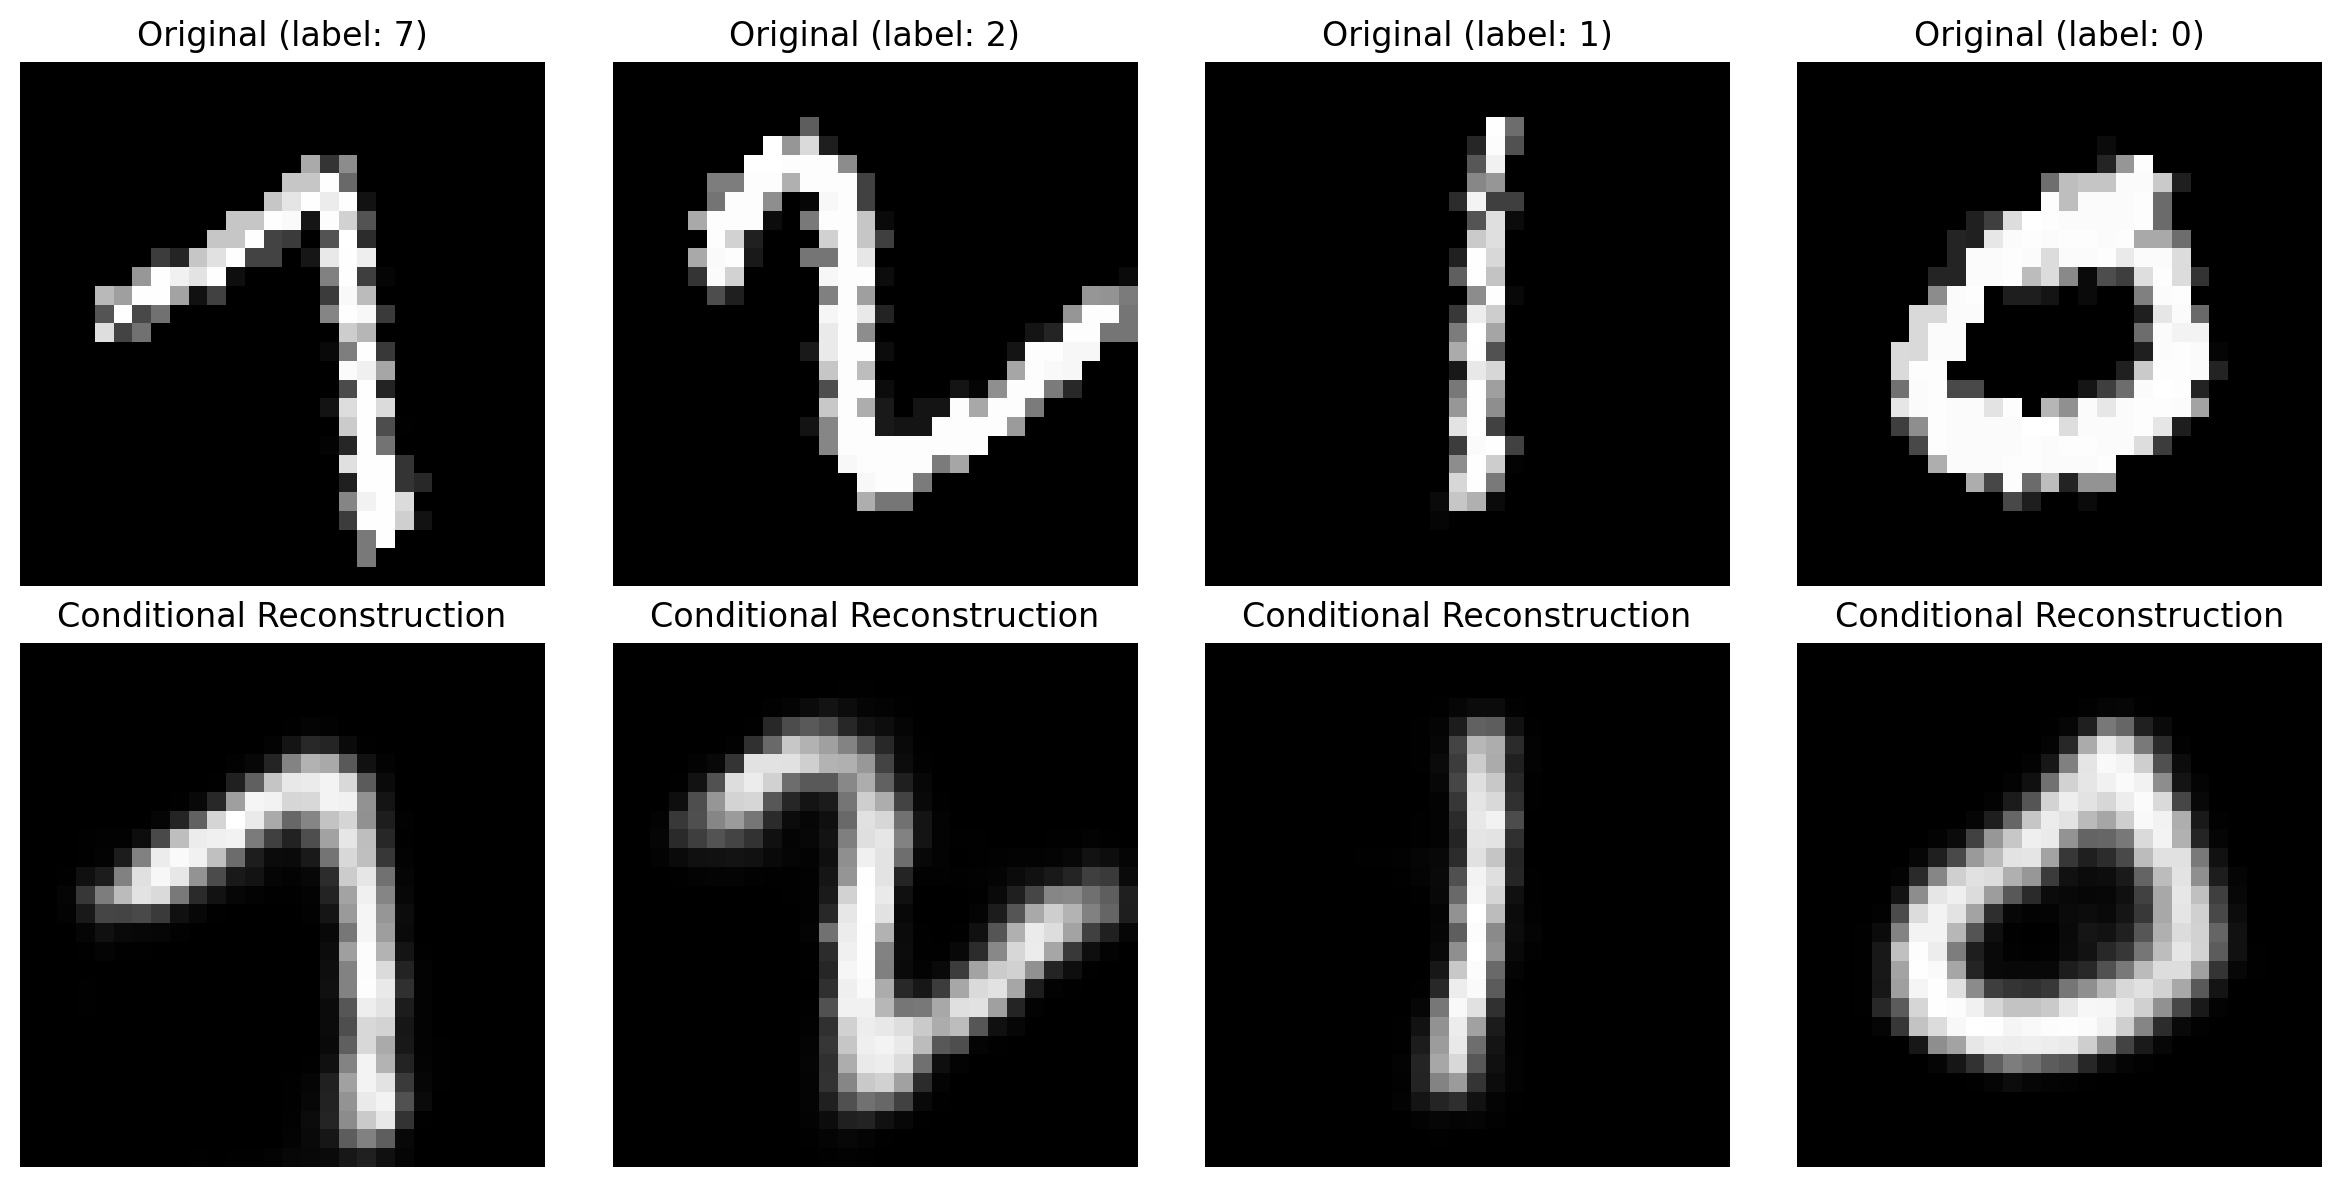

Computing conditional latent representations...
Processed batch 0/79
Processed batch 10/79
Processed batch 20/79
Processed batch 30/79
Processed batch 40/79
Processed batch 50/79
Processed batch 60/79
Processed batch 70/79
Running t-SNE on conditional latent space...


/Users/pablom.perez/miniconda3/envs/causalfm-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/pablom.perez/miniconda3/envs/causalfm-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/pablom.perez/miniconda3/envs/causalfm-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/pablom.perez/miniconda3/envs/causalfm-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/pablom.perez/miniconda3/envs/causalfm-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/pablom.perez/miniconda3/envs/causalfm-env/lib/python3.10/site-

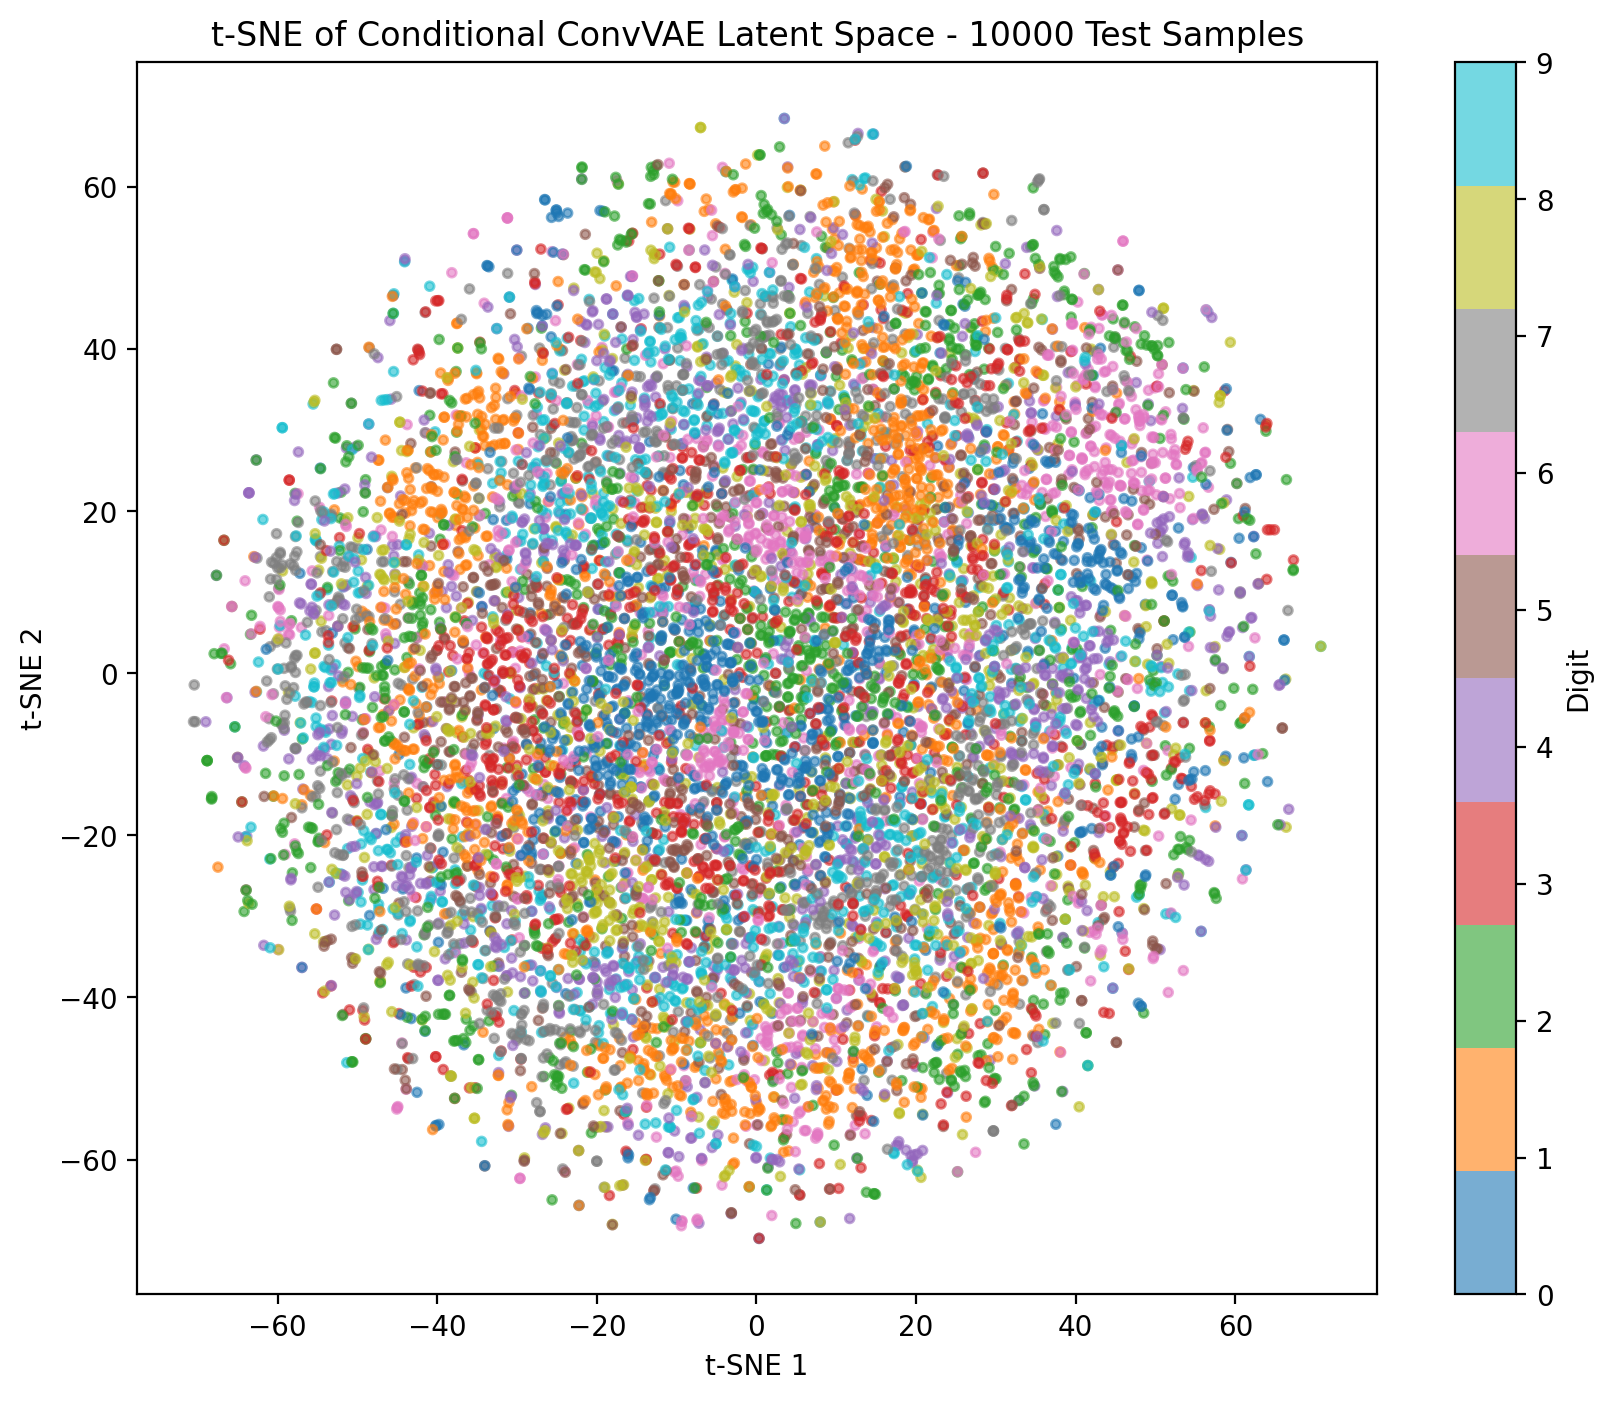


Generating samples conditioned on specific digits...


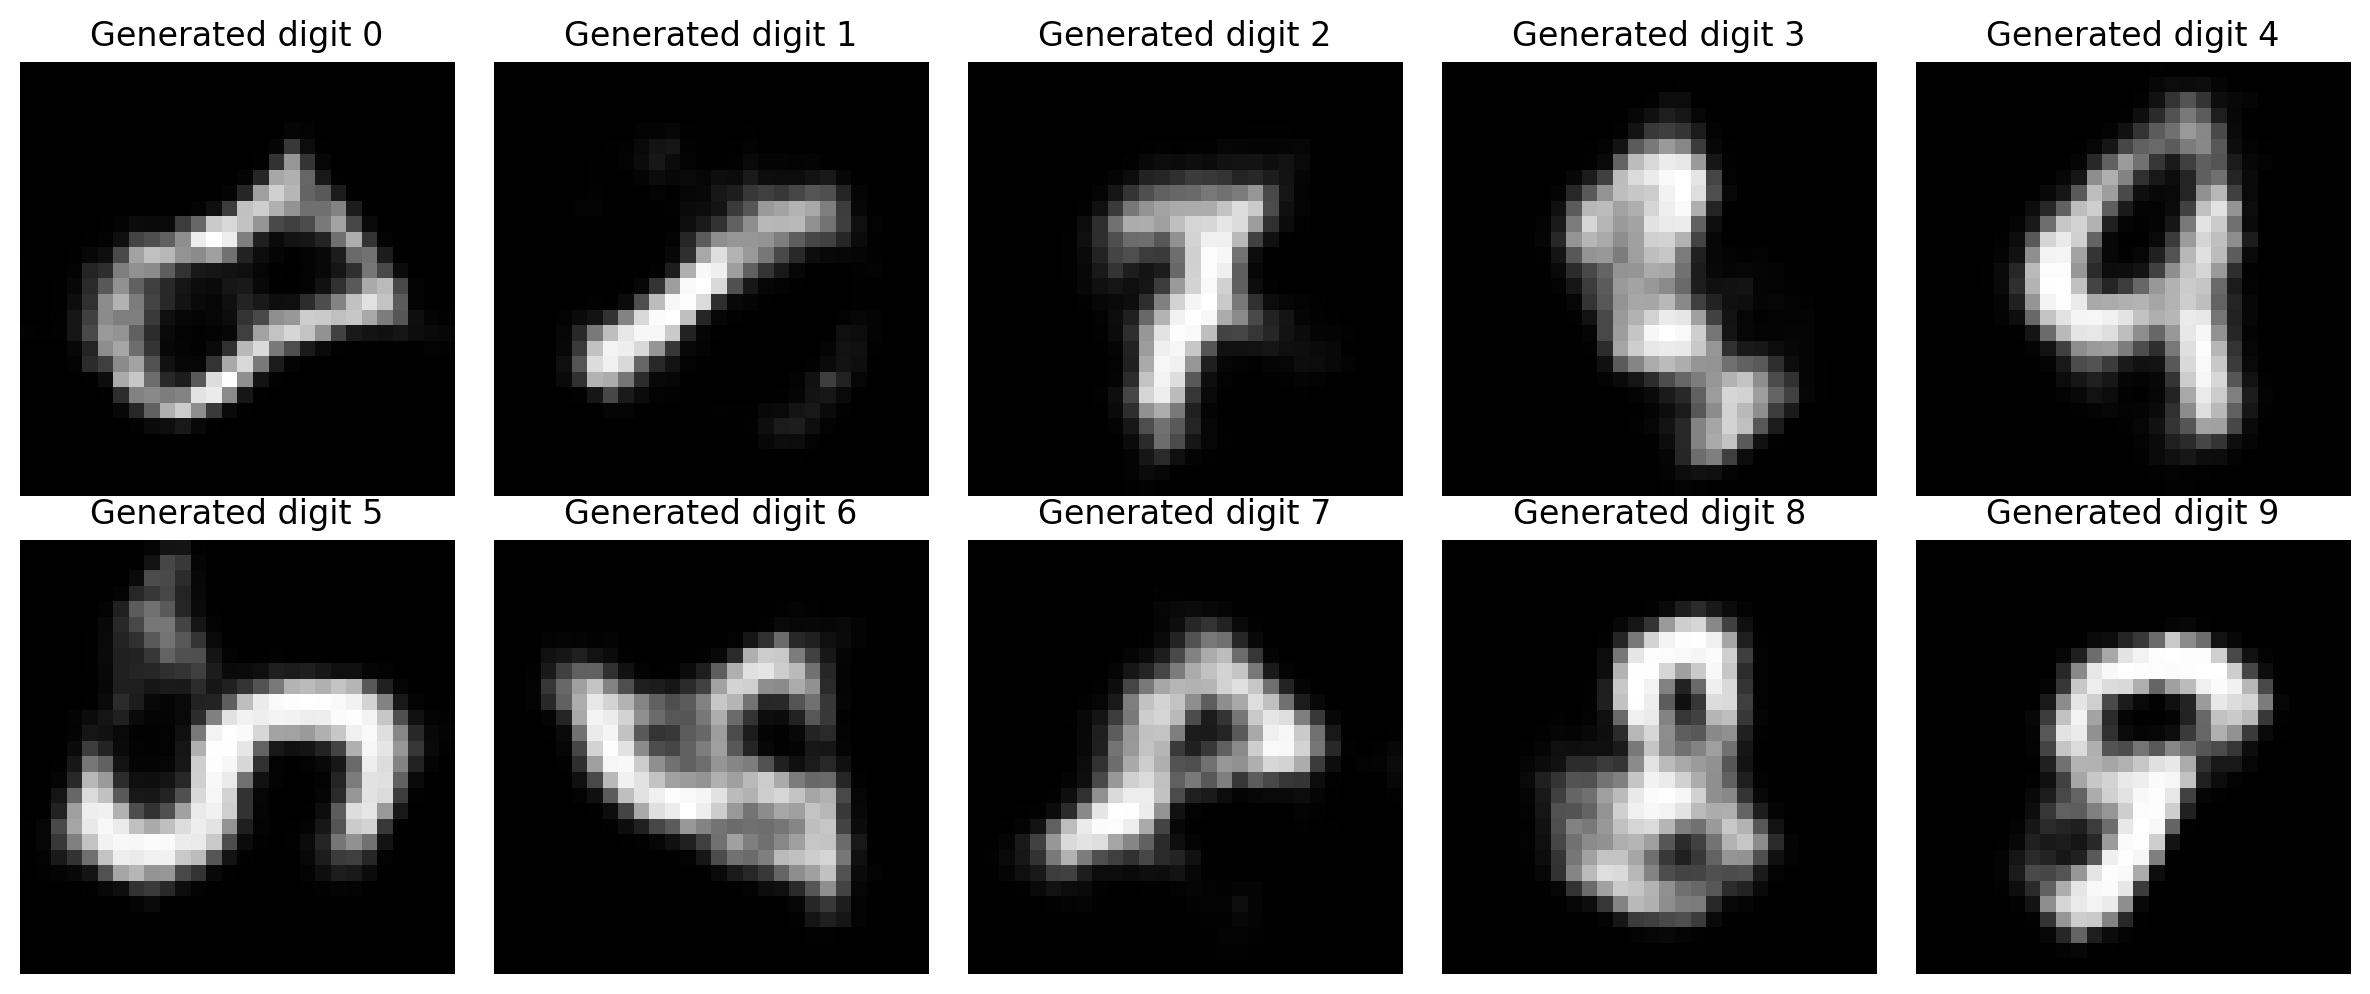

In [17]:

# Show conditional reconstructions
print("\nGenerating conditional reconstructions...")
examples, labels = next(iter(test_loader))
examples = examples[:4].to(device)
labels = labels[:4]

# Generate reconstructions with correct labels
with torch.no_grad():
    y_onehot = one_hot(labels, num_classes=10).to(device)
    reconstructions, _ = cond_vae(examples, y_onehot)

examples = examples.cpu().numpy()
reconstructions = reconstructions.cpu().numpy()

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
    axes[0, i].imshow(examples[i][0], cmap='gray')
    axes[0, i].set_title(f"Original (label: {labels[i]})")
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructions[i][0], cmap='gray')
    axes[1, i].set_title(f"Conditional Reconstruction")
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()


#import t-SNE
from sklearn.manifold import TSNE

# Visualize conditional latent space with t-SNE
print("Computing conditional latent representations...")
all_z_cond = []
all_labels_cond = []

cond_vae.eval()
with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(test_loader):
        data = data.to(device)
        y_onehot = one_hot(labels, num_classes=10).to(device)
        mu, logvar = cond_vae.encode(data)
        z = cond_vae.reparameterize(mu, logvar)
        all_z_cond.append(z.cpu().numpy())
        all_labels_cond.append(labels.numpy())
        if batch_idx % 10 == 0:
            print(f"Processed batch {batch_idx}/{len(test_loader)}")

all_z_cond = np.concatenate(all_z_cond, axis=0)
all_labels_cond = np.concatenate(all_labels_cond, axis=0)

print("Running t-SNE on conditional latent space...")
tsne_cond = TSNE(n_components=2, random_state=0, init='pca', learning_rate='auto')
z_2d_cond = tsne_cond.fit_transform(all_z_cond)

plt.figure(figsize=(10, 8))
plt.scatter(z_2d_cond[:, 0], z_2d_cond[:, 1], c=all_labels_cond, cmap='tab10', s=10, alpha=0.6)
plt.colorbar(label='Digit')
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title(f"t-SNE of Conditional ConvVAE Latent Space - {len(all_z_cond)} Test Samples")
plt.show()

# Generate samples conditioned on specific digits
print("\nGenerating samples conditioned on specific digits...")
cond_vae.eval()
with torch.no_grad():
    # Sample from prior
    z_samples = torch.randn(10, latent_dims).to(device)

    # Create one-hot conditions for digits 0-9
    digit_conditions = torch.eye(10).to(device)  # 10x10 identity matrix

    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    for i in range(10):
        row, col = i // 5, i % 5
        # Generate image for digit i
        generated = cond_vae.decode(z_samples[i:i+1], digit_conditions[i:i+1])
        axes[row, col].imshow(generated[0, 0].cpu().numpy(), cmap='gray')
        axes[row, col].set_title(f"Generated digit {i}")
        axes[row, col].axis('off')
    plt.tight_layout()
    plt.show()



Exercise: Reconstruct with different labels
Selected example with true label: 3


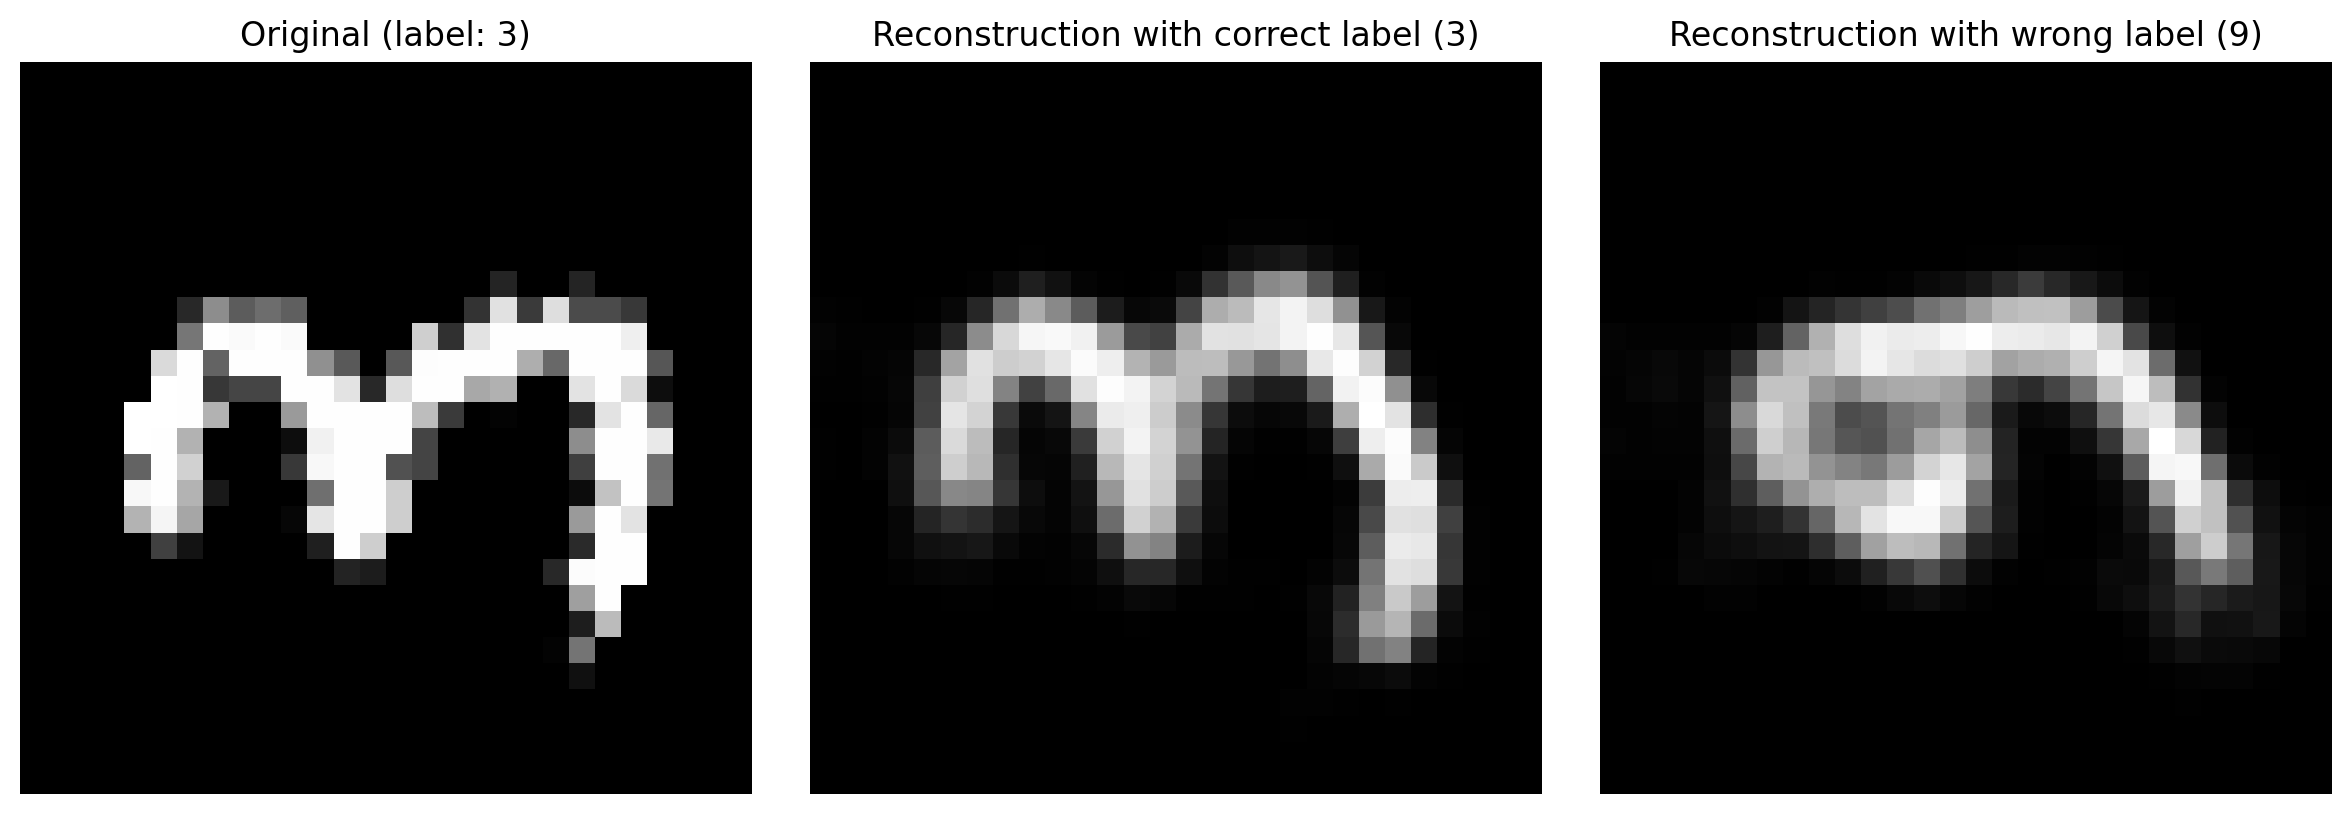

Comparison complete! Notice how the reconstruction changes when using different labels.


In [63]:

# ====== Exercise: Reconstruct with different labels ======
print("\n" + "="*50)
print("Exercise: Reconstruct with different labels")
print("="*50)

# Take one example from test set
test_example, test_label = next(iter(test_loader))
#take a random example of that batch
index=torch.randint(0, len(test_example), (1,))[0]
example = test_example[index:index+1].to(device)
#example = test_example[0:1].to(device)  # Take first example
true_label = test_label[index:index+1].item()

print(f"Selected example with true label: {true_label}")

# Extract latent representation
cond_vae.eval()
with torch.no_grad():
    # Encode to get latent z
    mu, logvar = cond_vae.encode(example)
    z = cond_vae.reparameterize(mu, logvar)

    # 1) Reconstruct with correct label
    correct_condition = one_hot(torch.tensor([true_label]), num_classes=10).to(device)
    reconstruction_correct = cond_vae.decode(z, correct_condition)

    # 2) Reconstruct with label '9'
    wrong_condition = one_hot(torch.tensor([9]), num_classes=10).to(device)
    reconstruction_wrong = cond_vae.decode(z, wrong_condition)

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Original
axes[0].imshow(example[0, 0].cpu().numpy(), cmap='gray')
axes[0].set_title(f"Original (label: {true_label})")
axes[0].axis('off')

# Reconstruction with correct label
axes[1].imshow(reconstruction_correct[0, 0].cpu().numpy(), cmap='gray')
axes[1].set_title(f"Reconstruction with correct label ({true_label})")
axes[1].axis('off')

# Reconstruction with wrong label
axes[2].imshow(reconstruction_wrong[0, 0].cpu().numpy(), cmap='gray')
axes[2].set_title(f"Reconstruction with wrong label (9)")
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Comparison complete! Notice how the reconstruction changes when using different labels.")


Computing latent representations for entire test set...
Processed batch 0/79
Processed batch 10/79
Processed batch 20/79
Processed batch 30/79
Processed batch 40/79
Processed batch 50/79
Processed batch 60/79
Processed batch 70/79
Total samples: 10000
Latent space shape: (10000, 32)


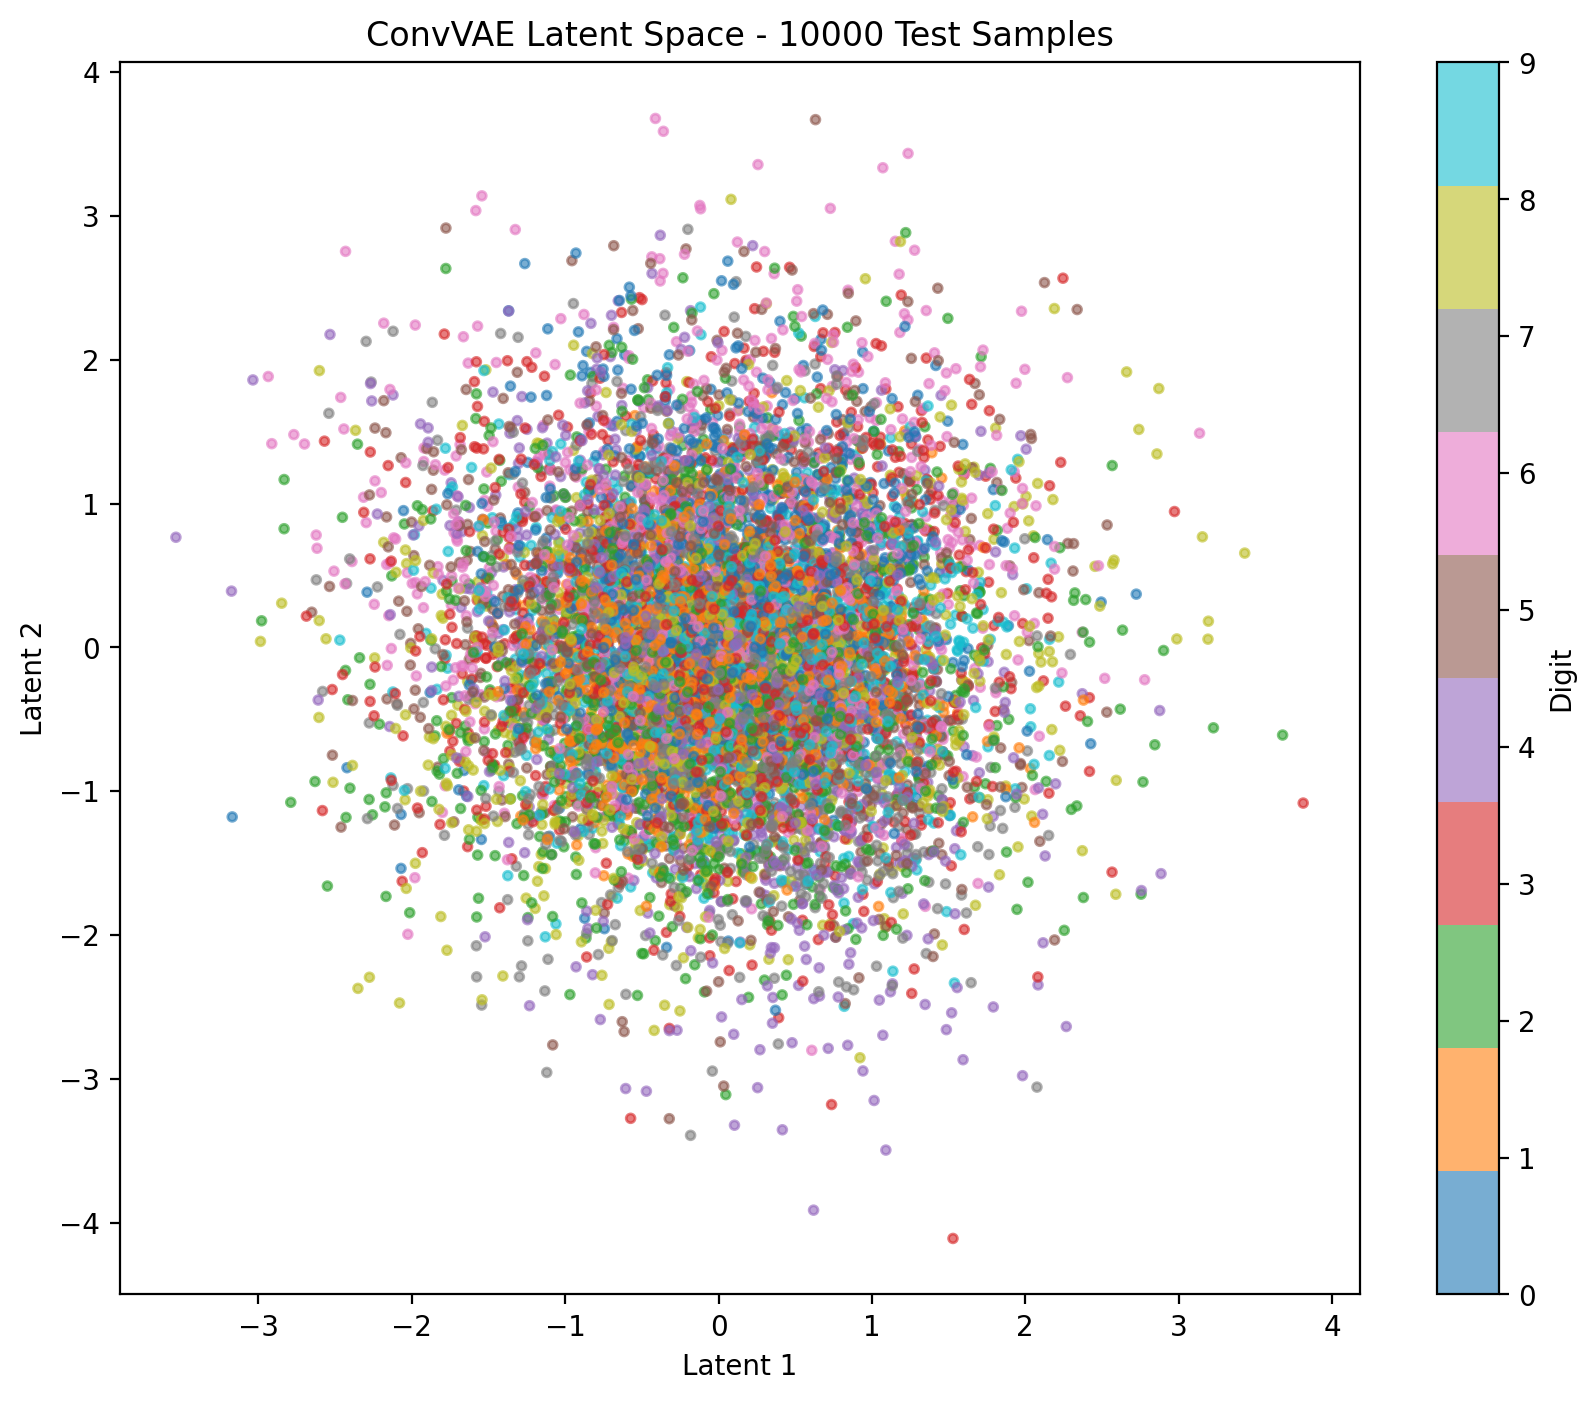

In [ ]:
### Visualize latent space
# Use the entire test set for better visualization
print("Computing latent representations for entire test set...")
all_z = []
all_labels = []

conv_vae.eval()  # Set to evaluation mode
with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(test_loader):
        data = data.to(device)
        mu, logvar = conv_vae.encode(data)
        z = conv_vae.reparameterize(mu, logvar)
        all_z.append(z.cpu().numpy())
        all_labels.append(labels.numpy())

        if batch_idx % 10 == 0:
            print(f"Processed batch {batch_idx}/{len(test_loader)}")

# Concatenate all batches
all_z = np.concatenate(all_z, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print(f"Total samples: {len(all_z)}")
print(f"Latent space shape: {all_z.shape}")

plt.figure(figsize=(10, 8))
plt.scatter(all_z[:, 0], all_z[:, 1], c=all_labels, cmap='tab10', s=10, alpha=0.6)
plt.colorbar(label='Digit')
plt.xlabel("Latent 1")
plt.ylabel("Latent 2")
plt.title(f"ConvVAE Latent Space - {len(all_z)} Test Samples")
plt.show()

Computing latent representations for entire test set...
Processed batch 0/79
Processed batch 10/79
Processed batch 20/79
Processed batch 30/79
Processed batch 40/79
Processed batch 50/79
Processed batch 60/79
Processed batch 70/79
Total samples: 10000
Latent space shape: (10000, 32)


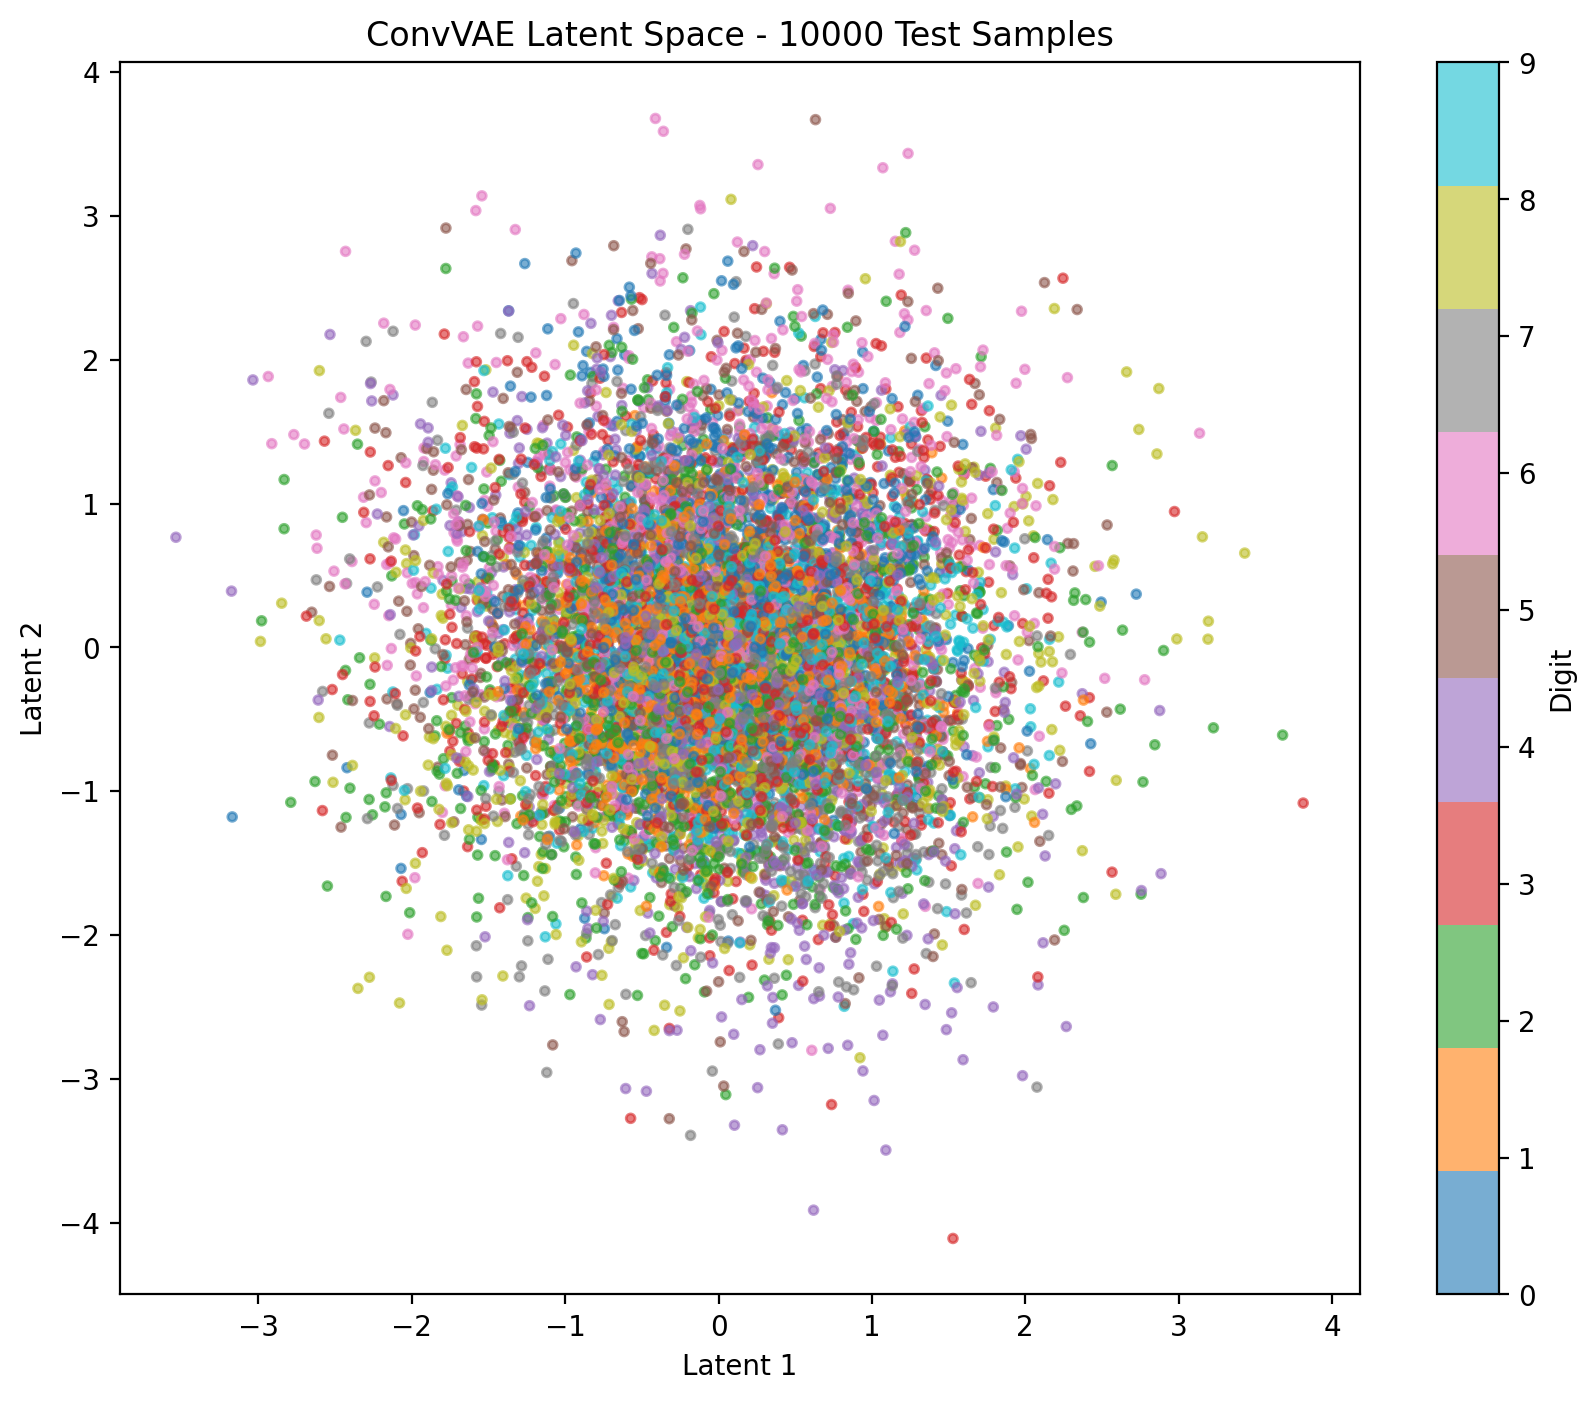

In [ ]:
### Visualize latent space
# Use the entire test set for better visualization
print("Computing latent representations for entire test set...")
all_z = []
all_labels = []

conv_vae.eval()  # Set to evaluation mode
with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(test_loader):
        data = data.to(device)
        mu, logvar = conv_vae.encode(data)
        z = conv_vae.reparameterize(mu, logvar)
        all_z.append(z.cpu().numpy())
        all_labels.append(labels.numpy())

        if batch_idx % 10 == 0:
            print(f"Processed batch {batch_idx}/{len(test_loader)}")

# Concatenate all batches
all_z = np.concatenate(all_z, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print(f"Total samples: {len(all_z)}")
print(f"Latent space shape: {all_z.shape}")

plt.figure(figsize=(10, 8))
plt.scatter(all_z[:, 0], all_z[:, 1], c=all_labels, cmap='tab10', s=10, alpha=0.6)
plt.colorbar(label='Digit')
plt.xlabel("Latent 1")
plt.ylabel("Latent 2")
plt.title(f"ConvVAE Latent Space - {len(all_z)} Test Samples")
plt.show()

Computing latent representations for entire test set...
Processed batch 0/79
Processed batch 10/79
Processed batch 20/79
Processed batch 30/79
Processed batch 40/79
Processed batch 50/79
Processed batch 60/79
Processed batch 70/79
Total samples: 10000
Latent space shape: (10000, 32)


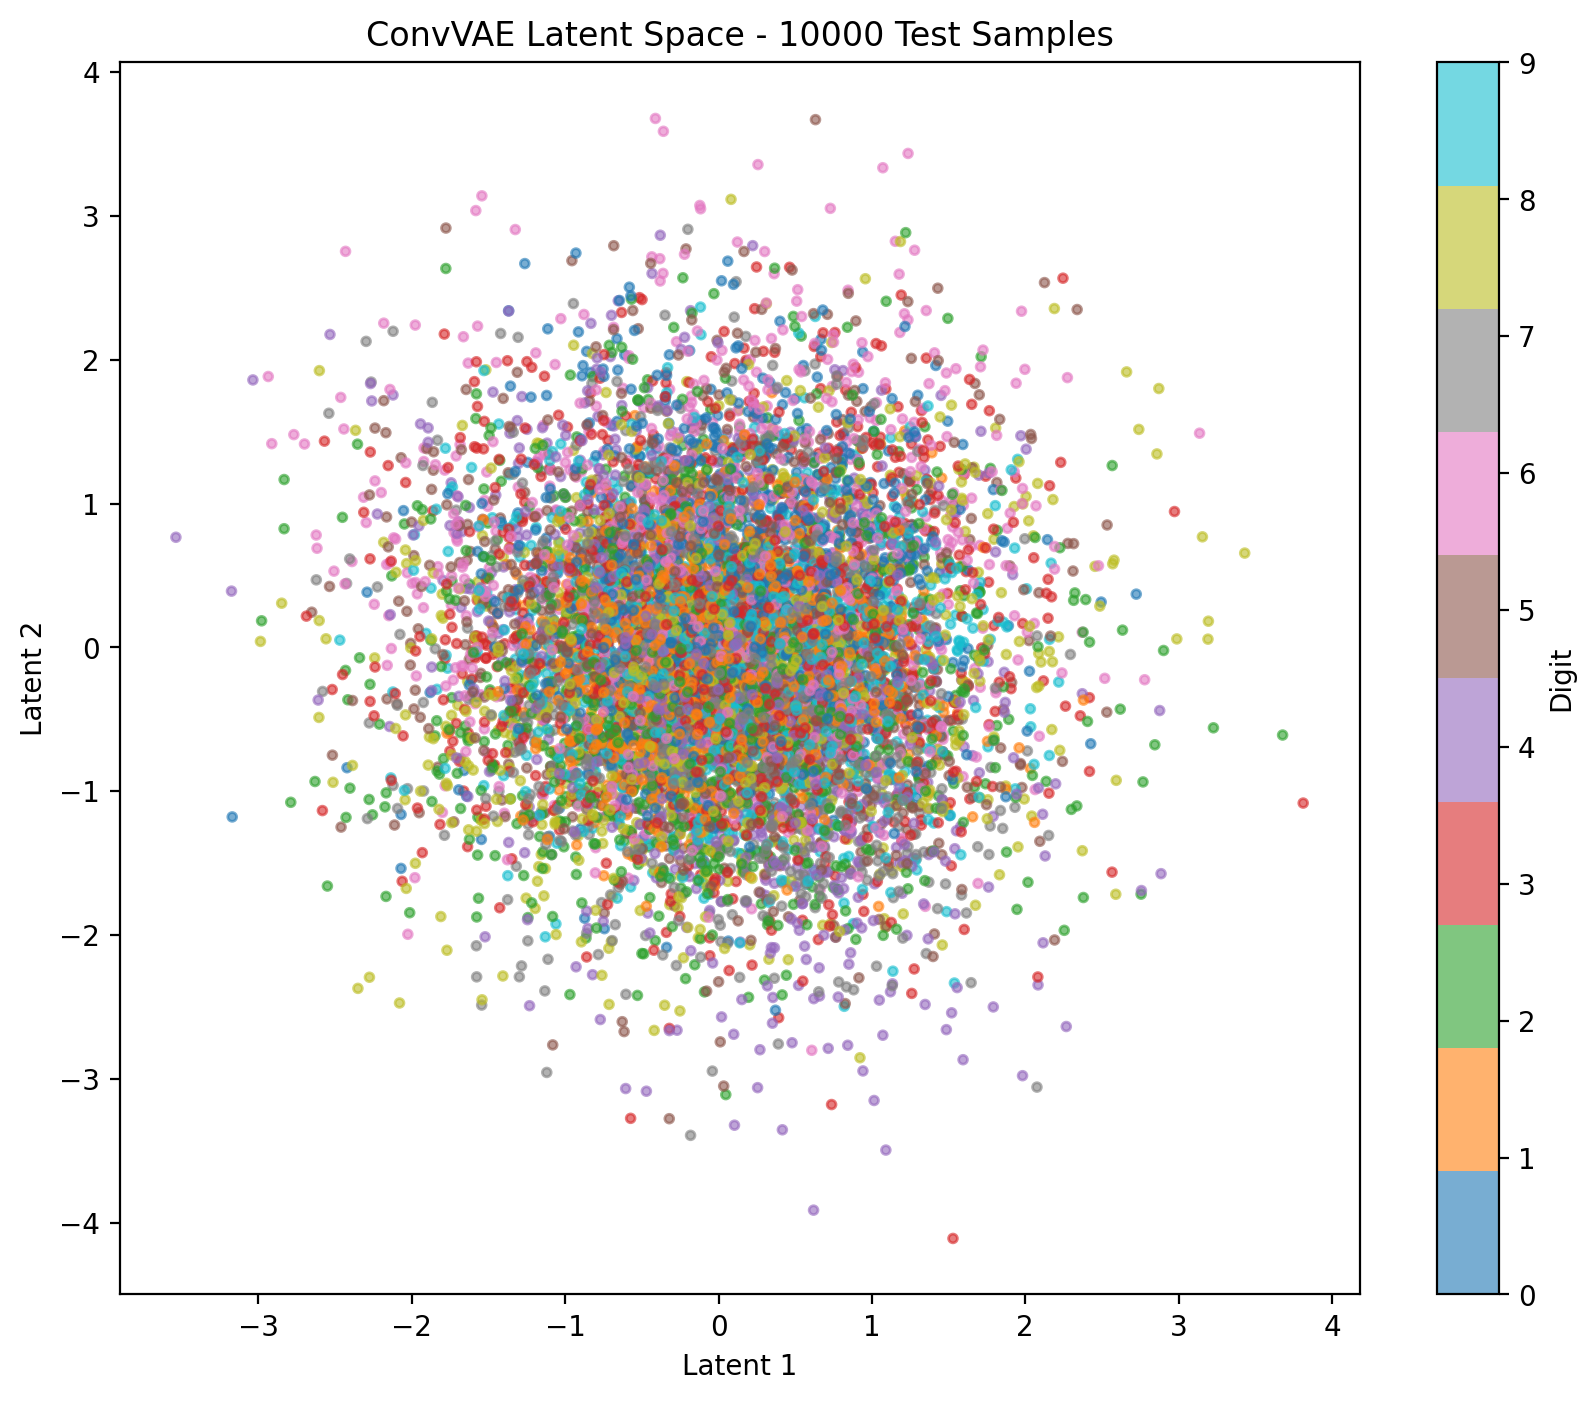

In [ ]:
### Visualize latent space
# Use the entire test set for better visualization
print("Computing latent representations for entire test set...")
all_z = []
all_labels = []

conv_vae.eval()  # Set to evaluation mode
with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(test_loader):
        data = data.to(device)
        mu, logvar = conv_vae.encode(data)
        z = conv_vae.reparameterize(mu, logvar)
        all_z.append(z.cpu().numpy())
        all_labels.append(labels.numpy())

        if batch_idx % 10 == 0:
            print(f"Processed batch {batch_idx}/{len(test_loader)}")

# Concatenate all batches
all_z = np.concatenate(all_z, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print(f"Total samples: {len(all_z)}")
print(f"Latent space shape: {all_z.shape}")

plt.figure(figsize=(10, 8))
plt.scatter(all_z[:, 0], all_z[:, 1], c=all_labels, cmap='tab10', s=10, alpha=0.6)
plt.colorbar(label='Digit')
plt.xlabel("Latent 1")
plt.ylabel("Latent 2")
plt.title(f"ConvVAE Latent Space - {len(all_z)} Test Samples")
plt.show()